In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from env import host, user, password
import acquire
import prepare

## Acquire Data

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def new_telco_data():
    '''
    This function reads the telco data from the Codeup db into a df.
    '''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    df = pd.read_sql(sql_query, get_connection('telco_churn'))

In [4]:
def get_telco_data():
    '''
    This function reads in iris data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df

In [5]:
df = acquire.get_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [6]:
df.shape

(7043, 24)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [9]:
def summarize_df(df):
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('------------------------')
    print(df.info())
    print('------------------------')
    print(df.head())
    
    
summarize_df(df)

This dataframe has 7043 rows and 24 columns.
------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object

## Prepare Data

In [10]:
# ALWAYS check for nulls

df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [11]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs. It is an all-in-all function.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn_encoded)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn_encoded)
    return train, validate, test

In [23]:
def prep_telco_data(df):
    
    # Drop duplicate columns
    df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)
    
    # Also dropping columns that won't be of use in this case, aka numeric
    
    # Drop null values stored as whitespace    
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    # Convert to correct datatype
    df['total_charges'] = df.total_charges.astype(float)
    
    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
    
    # split the data
    train, validate, test = split_telco_data(df)
    
    return train, validate, test

In [13]:
train, validate, test = prep_telco_data(df)

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3937, 47)
validate -> (1688, 47)
test -> (1407, 47)


In [14]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,0,0,0,1,0,0,0,1,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,0,0,0,1,0,1,0,1,0,0
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,1,0
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,0,1
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1


## Explore

In [15]:
train.churn_encoded.value_counts()

0    2891
1    1046
Name: churn_encoded, dtype: int64

Text(0.5, 0, 'Churned')

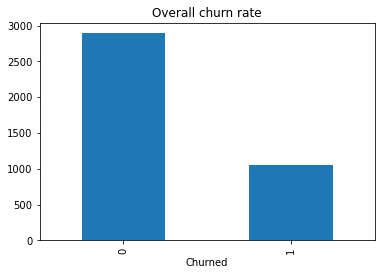

In [16]:
# plot churn
train.churn_encoded.value_counts().sort_index().plot.bar()
churn_rate = train.churn_encoded.mean()
plt.title(f"Overall churn rate")
plt.xlabel('Churned')

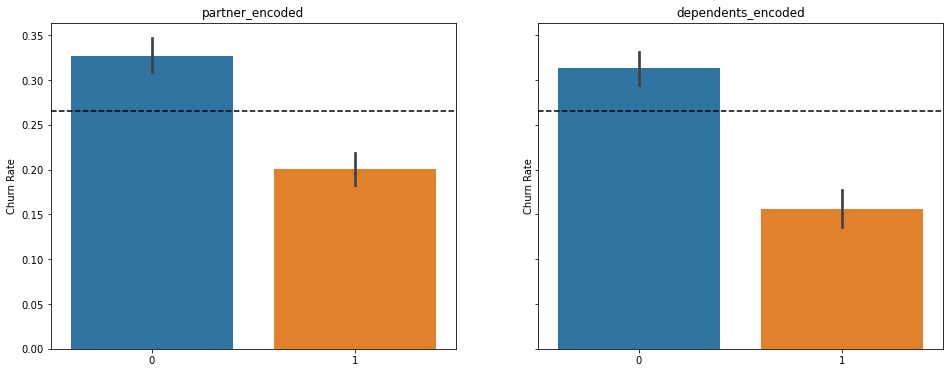

In [17]:
features = ['partner_encoded', 'dependents_encoded']
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways: 
    1. Those without dependents churn slightly more than those who have dependents.
    2. Those without partners tend to churn slightly more than those who have partners.
    3. What this says is that you are more likely to churn without a partner or dependent, but it is not significant. 

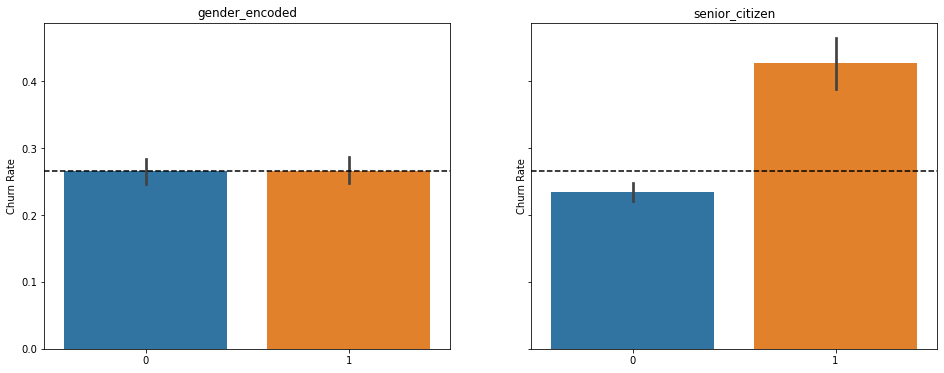

In [18]:
features = ['gender_encoded', 'senior_citizen']

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. Gender doesn't seem to have an impact on churn as it is equal.
2. There is a significant increase in churn among senior citizens than non senior citizens.

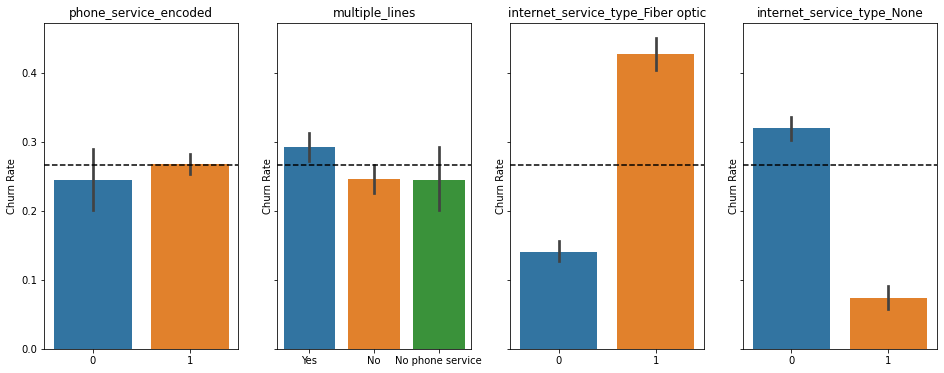

In [22]:
features = ['phone_service_encoded', 'multiple_lines', 'internet_service_type_Fiber optic', 'internet_service_type_None']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. Having phone service does not seem to impact churn.
2. The amount of phone lines do not seem to have an affect on churn.
3. There is a very significant churn with those who have fiber optic internet. 
4. There is a slightly significant churn among those without internet.

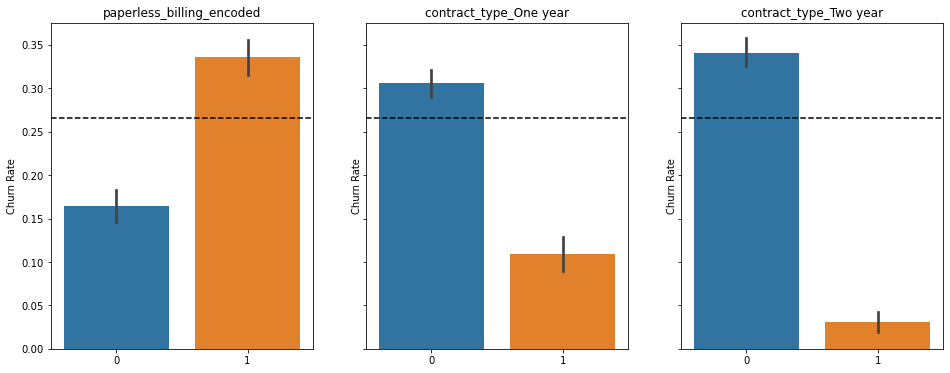

In [20]:
features = ['paperless_billing_encoded', 'contract_type_One year', 'contract_type_Two year']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. There is a significant churn rate among those who are paperless billing.
2. There is a not really a churn among one or two year contracts, so that piece of info is not important for reason for churn.

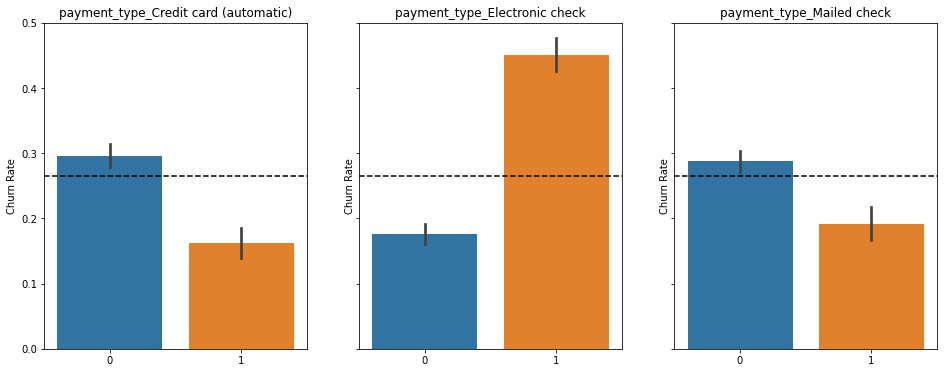

In [21]:
features = ['payment_type_Credit card (automatic)', 'payment_type_Electronic check', 'payment_type_Mailed check']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. Credit card payments are not likely to churn.
2. Electronic checks have a very significant churn rate.
3. Mailed checks are not likely to churn.

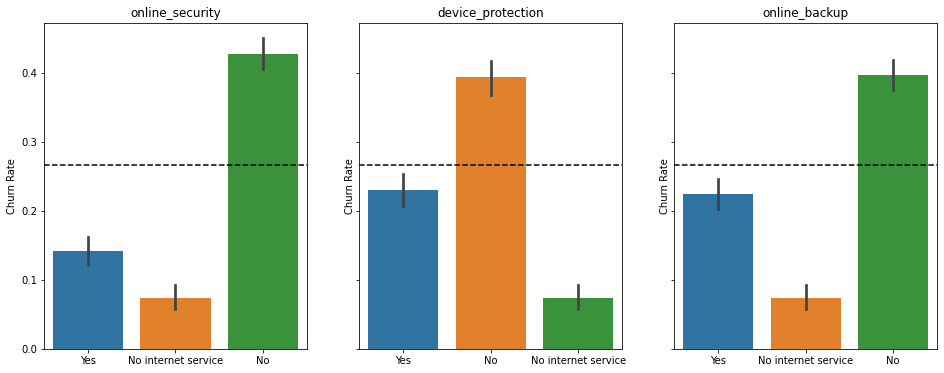

In [24]:
features = ['online_security', 'device_protection',  'online_backup']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways: 
1. Those without online security churn significantly.
2. Those without device protection churn sifnificantly.
3. Those with no online backup churn significantly.


This is big, because this shows a theme. 